# Load models and sample data

In [84]:
import os
import json
import inspect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from models.layers import FFNNConfig
from models.sde import Generator, DiscriminatorSimple, SdeGeneratorConfig

In [85]:
model_dir = "saved_models/best_dependent/"
with open(os.path.join(model_dir, "params_sde_ERCOT_tws.json"), "r") as f:
    params = json.load(f)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [86]:
from collections import defaultdict


def init_model_from_params(params):
    # Create generator noise embedding, drift, diffusion, readout, and discriminator network configuration objects
    configs = defaultdict(dict)
    ffnn_model_keys = ["embed", "drift", "diffusion", "readout", "dis"]
    for k, v in params.items():
        try:
            which_model, param_name = k.split("_", 1)
        except ValueError:
            continue

        if which_model not in ffnn_model_keys:
            continue
        configs[which_model][param_name] = v

    # Create generator and discriminator models
    generator_config_args = inspect.getfullargspec(SdeGeneratorConfig.__init__).args
    generator_config_args.remove("self")
    generator_config_params = {k: v for k, v in params.items() if k in generator_config_args}
    generator_config = SdeGeneratorConfig(
        **generator_config_params,
        embed_config=FFNNConfig(**configs["embed"]),
        drift_config=FFNNConfig(**configs["drift"]),
        diffusion_config=FFNNConfig(**configs["diffusion"]),
        readout_config=FFNNConfig(**configs["readout"])
    )

    generator = Generator(generator_config).to(device)
    if "num_filters" in configs["dis"]:
        configs["dis"]["num_units"] = configs["dis"].pop("num_filters")
    if "num_layers" in configs["dis"]:
        configs["dis"]["num_hidden_layers"] = configs["dis"].pop("num_layers")
    for opt_param in ["lr", "betas", "weight_decay"]:
        if opt_param in configs["dis"]:
            configs["dis"].pop(opt_param)
    configs["dis"]["in_size"] = params["data_size"] * params["time_series_length"]
    configs["dis"]["out_size"] = 1
    discriminator = DiscriminatorSimple(FFNNConfig(**configs["dis"])).to(device)
    return generator, discriminator


generator, discriminator = init_model_from_params(params)
generator.load_state_dict(torch.load(os.path.join(model_dir, "sde_gen_ERCOT_tws.pt"), map_location=device))
discriminator.load_state_dict(torch.load(os.path.join(model_dir, "sde_dis_ERCOT_tws.pt"), map_location=device))

generator_swa = torch.optim.swa_utils.AveragedModel(generator)
discriminator_swa = torch.optim.swa_utils.AveragedModel(discriminator)
generator_swa.load_state_dict(torch.load(os.path.join(model_dir, "sde_gen_swa_ERCOT_tws.pt"), map_location=device))
discriminator_swa.load_state_dict(torch.load(os.path.join(model_dir, "sde_dis_swa_ERCOT_tws.pt"), map_location=device))

<All keys matched successfully>

In [87]:
from dataloaders import get_sde_dataloader

segment_size = 24
batch_size = 1826
dataloader, _, _, transformer = get_sde_dataloader(
    iso="ERCOT",
    varname=["TOTALLOAD", "WIND", "SOLAR"],
    segment_size=segment_size,
    batch_size=batch_size,
    device=device,
    test_size=0.0,
    valid_size=0.0,
)

In [88]:
time_dep_str = "time_indep" if "independent" in model_dir else "time_dep"

# Generate samples
latent = generator.sample_latent(1826)
samples = generator.forward(latent)
samples = transformer.inverse_transform(samples).detach().cpu().numpy()
samples = np.concatenate(samples, axis=0)

samples_df = pd.DataFrame(samples, columns=["TOTALLOAD", "WIND", "SOLAR"])
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}.csv", index=False)

hours = np.arange(len(samples)).reshape(-1, 1) % segment_size
sample_num = np.arange(len(samples)).reshape(-1, 1) // segment_size
samples = np.hstack((sample_num, hours, samples))

samples_df = pd.DataFrame(samples, columns=["RAVEN_sample_ID", "HOUR", "TOTALLOAD", "WIND", "SOLAR"])
samples_df["RAVEN_sample_ID"] = samples_df["RAVEN_sample_ID"].astype(int)
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_sampleid.csv", index=False)


# Generate samples
samples = generator_swa.forward(latent)
samples = transformer.inverse_transform(samples).detach().cpu().numpy()
samples = np.concatenate(samples, axis=0)

samples_df = pd.DataFrame(samples, columns=["TOTALLOAD", "WIND", "SOLAR"])
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_swa.csv", index=False)

hours = np.arange(len(samples)).reshape(-1, 1) % segment_size
sample_num = np.arange(len(samples)).reshape(-1, 1) // segment_size
samples = np.hstack((sample_num, hours, samples))

samples_df = pd.DataFrame(samples, columns=["RAVEN_sample_ID", "HOUR", "TOTALLOAD", "WIND", "SOLAR"])
samples_df["RAVEN_sample_ID"] = samples_df["RAVEN_sample_ID"].astype(int)
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_sampleid_swa.csv", index=False)

In [89]:
time_dep_str = "time_indep" if "independent" in model_dir else "time_dep"
ts = torch.linspace(0.0, 23.75, steps=segment_size*4)
hours = np.tile(np.linspace(0, 23.75, segment_size*4), 1826).reshape(-1, 1)
sample_num = np.repeat(np.arange(1826).reshape(-1, 1), segment_size*4, axis=0)

# Generate samples
latent = generator.sample_latent(1826)
samples = generator.forward(latent, ts=ts)
samples = transformer.inverse_transform(samples).detach().cpu().numpy()
samples = np.concatenate(samples, axis=0)

samples_df = pd.DataFrame(samples, columns=["TOTALLOAD", "WIND", "SOLAR"])
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_15min.csv", index=False)

samples = np.hstack((sample_num, hours, samples))

samples_df = pd.DataFrame(samples, columns=["RAVEN_sample_ID", "HOUR", "TOTALLOAD", "WIND", "SOLAR"])
samples_df["RAVEN_sample_ID"] = samples_df["RAVEN_sample_ID"].astype(int)
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_sampleid_15min.csv", index=False)


# Generate samples
samples = generator_swa.forward(latent, ts=ts)
samples = transformer.inverse_transform(samples).detach().cpu().numpy()
samples = np.concatenate(samples, axis=0)

samples_df = pd.DataFrame(samples, columns=["TOTALLOAD", "WIND", "SOLAR"])
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_swa_15min.csv", index=False)

samples = np.hstack((sample_num, hours, samples))

samples_df = pd.DataFrame(samples, columns=["RAVEN_sample_ID", "HOUR", "TOTALLOAD", "WIND", "SOLAR"])
samples_df["RAVEN_sample_ID"] = samples_df["RAVEN_sample_ID"].astype(int)
samples_df.to_csv(f"ercot_samples_sde_{time_dep_str}_sampleid_swa_15min.csv", index=False)

# Load samples from file and plot

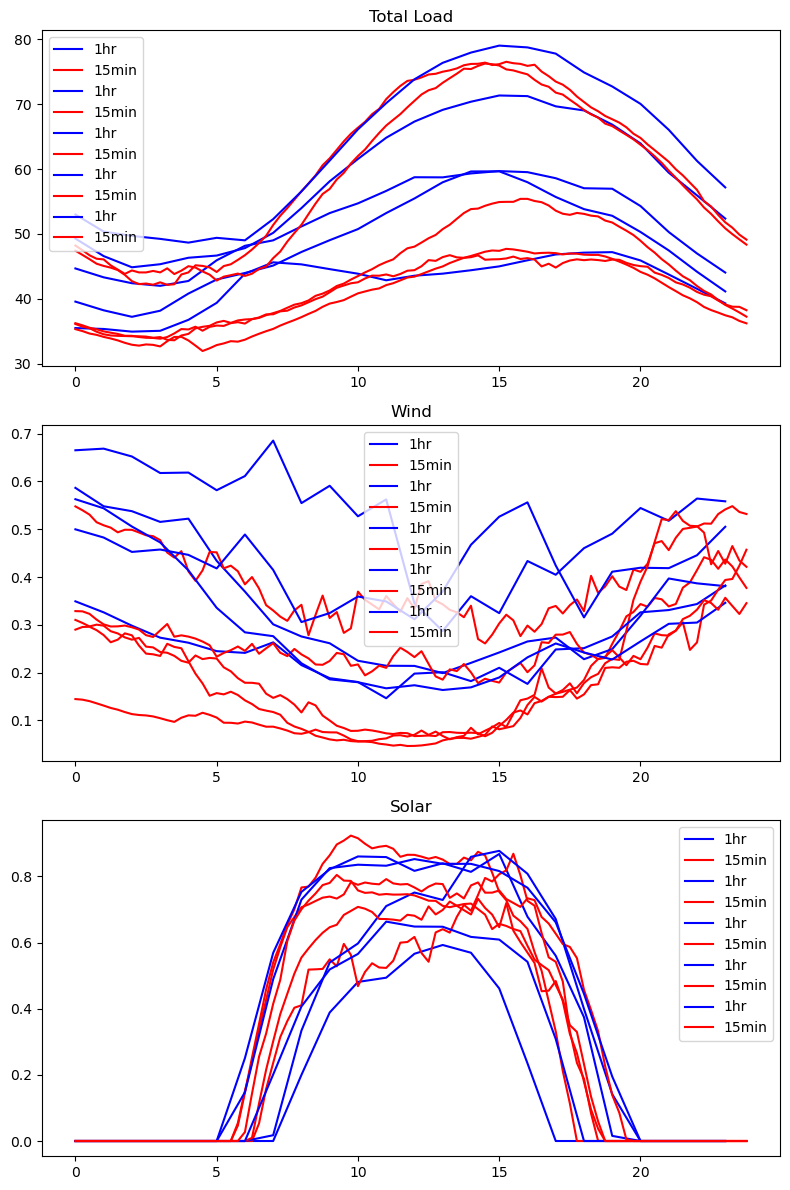

In [98]:
samples_1hr = pd.read_csv("ercot_samples_sde_time_indep_sampleid_swa.csv")
samples_15min = pd.read_csv("ercot_samples_sde_time_indep_sampleid_swa_15min.csv")

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i in range(5):
    hourly_sample = samples_1hr[samples_1hr["RAVEN_sample_ID"] == i]
    min15_sample = samples_15min[samples_15min["RAVEN_sample_ID"] == i]
    ax[0].plot(hourly_sample["HOUR"], hourly_sample["TOTALLOAD"], label="1hr", color="b")
    ax[0].plot(min15_sample["HOUR"], min15_sample["TOTALLOAD"], label="15min", color="r")
    ax[0].set_title("Total Load")
    ax[0].legend()
    ax[1].plot(hourly_sample["HOUR"], hourly_sample["WIND"], label="1hr", color="b")
    ax[1].plot(min15_sample["HOUR"], min15_sample["WIND"], label="15min", color="r")
    ax[1].set_title("Wind")
    ax[1].legend()
    ax[2].plot(hourly_sample["HOUR"], hourly_sample["SOLAR"], label="1hr", color="b")
    ax[2].plot(min15_sample["HOUR"], min15_sample["SOLAR"], label="15min", color="r")
    ax[2].set_title("Solar")
    ax[2].legend()
plt.tight_layout()
plt.show()